## Partial dependence plot: Explainability

### Summary of the results
Worth seeing is the result from XGBoost model. Interesting is second XGBoost model considering only date, month, year as independent variables. This model is a much more plausible comparing to others. However I could not explain at this particular model the partial dependence plot of temperature on month provides more accuracy. I can only guess that other variables don't have more predictive power toward temperature.
**In this workbook**:
- Import and clean data
- Train the data set with Random Forest, XG Boost and Neural Network to predict temperature.
- Plausibility check the model with Partial Dependence Plot

In [1]:
import pandas as pd 
import numpy as np 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import r2_score 

import warnings 
warnings.filterwarnings('ignore')
from sklearn.inspection import PartialDependenceDisplay


### Import and clean data

In [2]:
df = pd.read_csv(r"D:\ACER\Documents\Master_Hochschule_Harz\2.Semester\Machine Learning\Abgabe\Abgabe 4\tageswerte_KL_05490_19470101_20221231_hist\produkt_klima_tag_19470101_20221231_05490.txt",sep = ";")
df = df.where(df != -999,np.nan)
df.columns = ['STATIONS_ID', 'MESS_DATUM', 'QN_3', 'FX', 'FM', 'QN_4', 'RSK',
       'RSKF', 'SDK', 'SHK_TAG', 'NM', 'VPM', 'PM', 'TMK', 'UPM',
       'TXK', 'TNK', 'TGK', 'eor']
df

,STATIONS_ID,MESS_DATUM,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
0,5490,19470101,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.1,987.20,-5.2,89.00,-2.4,-8.6,-10.4,eor
1,5490,19470102,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,6.5,991.80,-1.9,97.00,-0.6,-8.2,-9.5,eor
2,5490,19470103,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,5.9,1000.00,-3.8,95.00,-0.4,-4.0,-8.0,eor
3,5490,19470104,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,3.3,1004.20,-9.9,82.00,-4.0,-11.0,-14.0,eor
4,5490,19470105,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,2.1,997.90,-14.8,84.00,-10.6,-16.0,-17.4,eor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27741,5490,20221227,3.0,17.8,5.6,3.0,0.4,6.0,2.000,0.0,5.2,6.0,993.73,4.5,71.46,5.5,3.3,1.1,eor
27742,5490,20221228,3.0,17.2,5.4,3.0,0.9,6.0,0.000,0.0,7.7,7.5,984.37,6.6,76.33,8.5,3.9,3.0,eor
27743,5490,20221229,3.0,17.6,5.6,3.0,3.1,6.0,0.833,0.0,6.5,8.5,977.18,9.7,70.92,11.6,7.7,5.7,eor
27744,5490,20221230,3.0,18.9,5.9,3.0,1.8,6.0,0.733,0.0,5.7,7.4,981.30,7.5,71.04,11.7,5.7,2.6,eor


In [3]:

dateTempMiss = np.array(df.MESS_DATUM)
#mess_datum column is integer
dateTempMiss = dateTempMiss.astype(str)
year = []
month= []
date = []
for i in range(len(dateTempMiss)):
    dateObject = datetime.datetime.strptime(dateTempMiss[i],'%Y%m%d') #transform to a date time object
    getYear = dateObject.year
    getMonth = dateObject.month
    getDate = dateObject.day
    year.append(getYear)
    month.append(getMonth)
    date.append(getDate)
df['Year'] = year
df['Month'] = month
df['Date'] = date
df['n_days'] = [i -19470101 for i in df.MESS_DATUM]


Should not use VPM, which is can be calculated from temperature

In [4]:
scaler = StandardScaler() 
data = df[['FX','FM','RSK','RSKF','SDK','SHK_TAG','NM','VPM', 'PM', 'UPM', 'TXK', 'TNK', 'TGK', 'TMK']]
scaler.fit(data)
std_data = pd.DataFrame(scaler.transform(data))
std_data.columns = ['FX','FM','std_RSK','RSKF','SDK','SHK_TAG','NM','VPM', 'PM', 'UPM', 'TXK', 'TNK', 'TGK','std_TMK']
data1= df[['STATIONS_ID', 'MESS_DATUM','Year', 'Month', 'Date','n_days','TMK', 'RSK']]
std_df = pd.concat([data1, std_data], axis=1)
std_df


,STATIONS_ID,MESS_DATUM,Year,Month,Date,n_days,TMK,RSK,FX,FM,...,SDK,SHK_TAG,NM,VPM,PM,UPM,TXK,TNK,TGK,std_TMK
0,5490,19470101,1947,1,1,0,-5.2,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.061902,-0.002714,1.301729,-1.823242,-1.958857,-1.957000,-1.904589
1,5490,19470102,1947,1,2,1,-1.9,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.690478,0.514662,2.017523,-1.611250,-1.900516,-1.825684,-1.461638
2,5490,19470103,1947,1,3,2,-3.8,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.849660,1.436940,1.838574,-1.587695,-1.287932,-1.606823,-1.716671
3,5490,19470104,1947,1,4,3,-9.9,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.539448,1.909327,0.675408,-2.011679,-2.308906,-2.482266,-2.535458
4,5490,19470105,1947,1,5,4,-14.8,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.857812,1.200747,0.854357,-2.788983,-3.038173,-2.978350,-3.193173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27741,5490,20221227,2022,12,27,751126,4.5,0.4,1.032201,0.974060,...,-0.611943,-0.263182,-0.223293,-0.823129,0.731735,-0.267651,-0.892833,-0.223201,-0.279069,-0.602583
27742,5490,20221228,2022,12,28,751127,6.6,0.9,0.921828,0.881798,...,-1.101831,-0.263182,0.944889,-0.425174,-0.321012,0.168089,-0.539513,-0.135689,-0.001846,-0.320705
27743,5490,20221229,2022,12,29,751128,9.7,3.1,0.995410,0.974060,...,-0.897792,-0.263182,0.384162,-0.159871,-1.129693,-0.315967,-0.174416,0.418554,0.392103,0.095400
27744,5490,20221230,2022,12,30,751129,7.5,1.8,1.234552,1.112454,...,-0.922287,-0.263182,0.010343,-0.451705,-0.666305,-0.305230,-0.162639,0.126847,-0.060209,-0.199900


### Create function for Partial dependence plot

In [96]:
def pdd_plot(X, fit_model):
    mean= np.mean(X, axis =0)
    if len(X.columns) <=3:
        fig, axs = plt.subplots(3, figsize = (10,10))
    else:
        fig, axs = plt.subplots(-(-len(X.columns)//3),3, figsize = (20,20))
    #loop through each variable, while main var has the true values, other vars take their mean (repeated with len(X))
    for i in range(len(X.columns)):
        mean1=np.array([mean[:i]] * len(X))
        mean2 = np.array([mean[i+1:len(X.columns)]] * len(X))
        main_var = np.array(sorted(X.iloc[:,i]))
        data_dict = { **dict(zip(X.columns[:i], mean1.T)), X.columns[i]: main_var, **dict(zip(X.columns[i+1:], mean2.T))}
        data = pd.DataFrame(data_dict)
        y = fit_model.predict(data)
        if len(X.columns) == 3:
            axs[i].plot(main_var,y)
            axs[i].set_title(str(X.columns[i]))
        elif i <3:
            axs[0,i].plot(main_var, y)
            axs[0,i].set_title(str(X.columns[i]))
        elif 3<= i <6:
            axs[1,i-3].plot(main_var, y)
            axs[1,i-3].set_title(str(X.columns[i]))
        else:
            axs[2,i-6].plot(main_var, y)
            axs[2,i-6].set_title(str(X.columns[i]))

In [71]:
def residual_plot(X_train, y_train, model):
    y_model = model.predict(X_train)
    residual = y_model - y_train
    fig, axs = plt.subplots(2, figsize=(10, 10))

    # Scatter plot
    axs[0].scatter(np.arange(0, len(residual), 1), residual, marker='o', s=1)
    axs[0].set_title('Residuals Scatter Plot')

    # Histogram
    axs[1].hist(residual, bins=50)
    axs[1].set_title('Residuals Histogram')

    plt.show()

# Example usage
# Assuming X_train and y_train are your training data and labels, and model is your trained model
# residual_plot(X_train, y_train, model)


Datasets:
- X_train1: 'Year','Month','Date'
- X_train: 'std_RSK','RSKF','UPM','TXK','TNK','Year','Month','Date'
- X_train3: only variables that have high correlation with temperature: 'UPM','TXK','TNK','n_days'

In [25]:
data_time = std_df[['Year','Month','Date','TMK']].dropna(axis = 0, how = 'any')
X_multiple_time = data_time.drop(columns=['TMK'])
y_time =data_time.TMK
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_multiple_time, y_time, test_size=0.2)

In [ ]:
data2 = std_df[['std_RSK','RSKF','UPM','TXK','TNK','Year','Month','Date','TMK']].dropna(axis = 0, how = 'any')
X_multiple2 = data2.drop(columns=['TMK'])
y2 =data2.TMK
X_train, X_test, y_train, y_test = train_test_split(X_multiple2, y2, test_size=0.2)

In [98]:
data3 = std_df[['UPM','TXK','TNK','TGK','n_days','TMK']].dropna(axis = 0, how = 'any')
X_multiple3 = data3.drop(columns=['TMK'])
y3 =data3.TMK
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_multiple3, y3, test_size=0.2)

### Random forest

In [7]:

randomForest = RandomForestRegressor(random_state= 0, bootstrap=True, max_depth=2 ) #control the randomness of bootstrapping
randomForest.fit(X_train, y_train)
y_pred_forest = randomForest.predict(X_test)
accuracy_score = r2_score(y_test, y_pred_forest) 
print('Accuracy score:', accuracy_score) 

Accuracy score: 0.8736891166150594


In [8]:
randomForest.decision_path(X_train)

(<20308x700 sparse matrix of type '<class 'numpy.int64'>'
 	with 6092400 stored elements in Compressed Sparse Row format>,
 array([  0,   7,  14,  21,  28,  35,  42,  49,  56,  63,  70,  77,  84,
         91,  98, 105, 112, 119, 126, 133, 140, 147, 154, 161, 168, 175,
        182, 189, 196, 203, 210, 217, 224, 231, 238, 245, 252, 259, 266,
        273, 280, 287, 294, 301, 308, 315, 322, 329, 336, 343, 350, 357,
        364, 371, 378, 385, 392, 399, 406, 413, 420, 427, 434, 441, 448,
        455, 462, 469, 476, 483, 490, 497, 504, 511, 518, 525, 532, 539,
        546, 553, 560, 567, 574, 581, 588, 595, 602, 609, 616, 623, 630,
        637, 644, 651, 658, 665, 672, 679, 686, 693, 700]))

In [9]:
randomForest.feature_importances_

array([0., 0., 0., 1., 0., 0., 0., 0.])

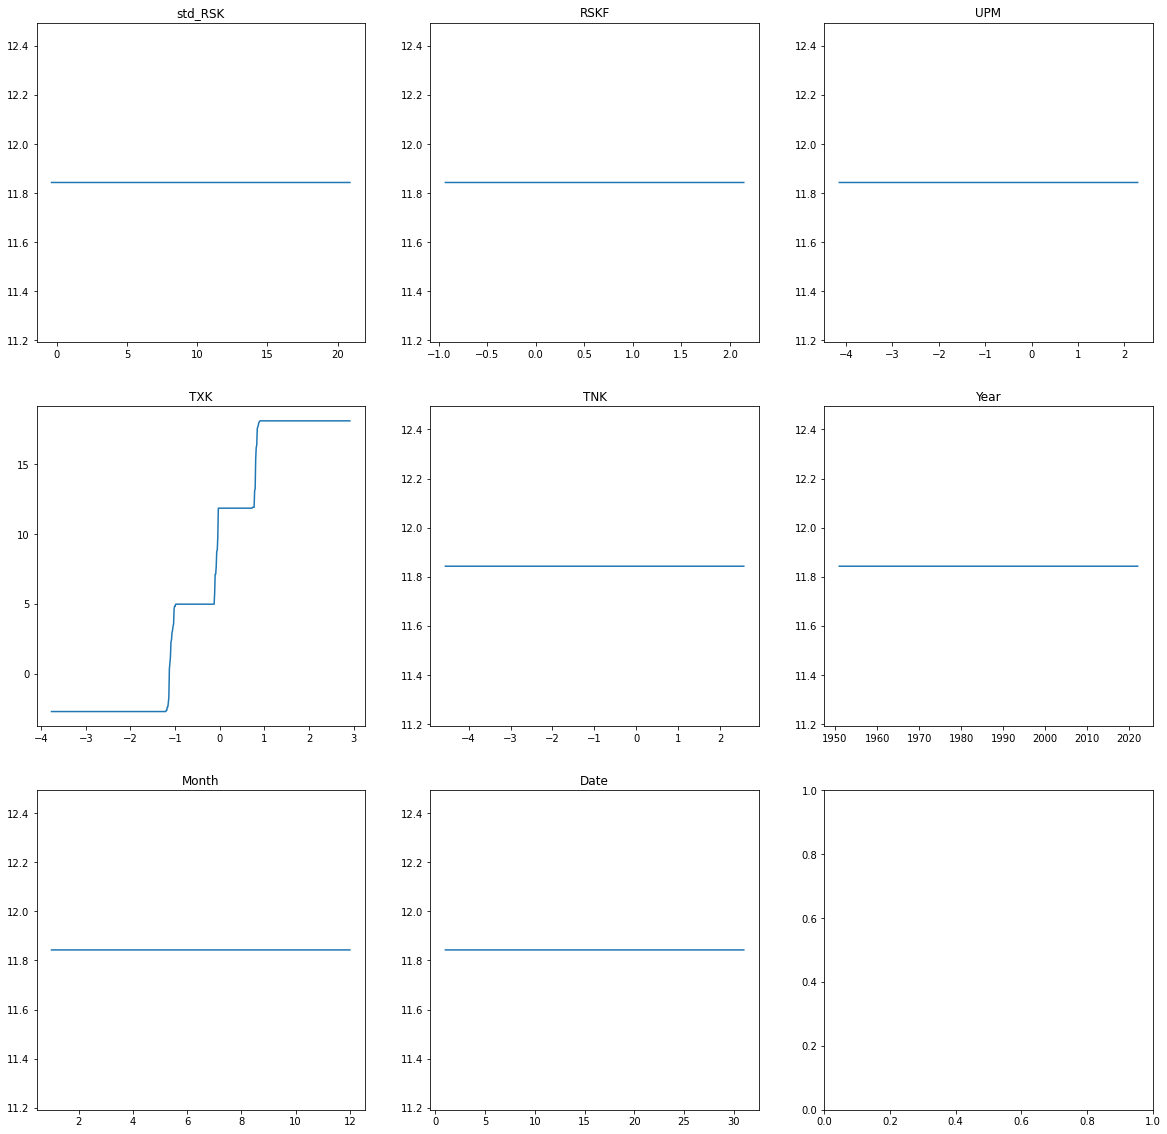

In [11]:
pdd_plot(X_train,randomForest)

It looks like only TXK matters in the model. Other variables are not important in the prediction of temperature. This is not plausible because temperature clearly depends on month. 

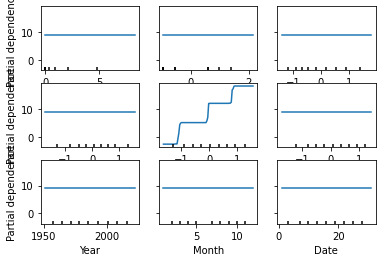

In [20]:
PartialDependenceDisplay.from_estimator(randomForest,X_train, features= [(i,) for i in range(len(X_train.columns))], feature_names=X_train.columns)
#plt.barh(X_train.columns, xgb.feature_importances_)

In [99]:
randomForest3 = RandomForestRegressor(random_state= 0, bootstrap=True, max_depth=2 ) #control the randomness of bootstrapping
randomForest3.fit(X_train3, y_train3)
y_pred_forest3 = randomForest3.predict(X_test3)
accuracy_score3 = r2_score(y_test3, y_pred_forest3) 
print('Accuracy score:', accuracy_score3) 

Accuracy score: 0.8694465600168286


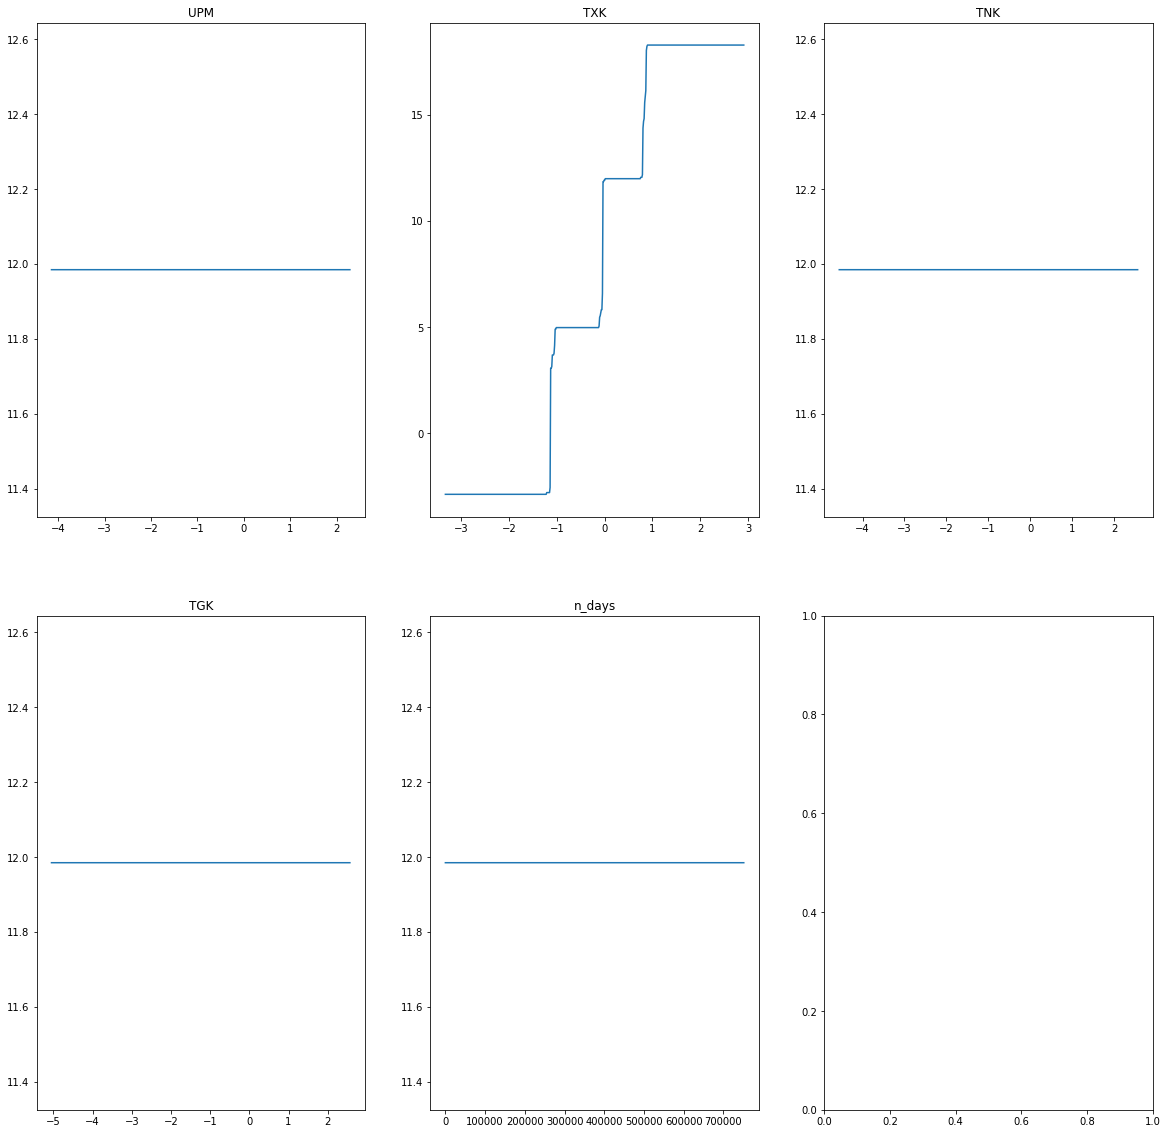

In [100]:
pdd_plot(X_train3,randomForest3)

### XG Boost

In [29]:
import warnings 
warnings.filterwarnings('ignore')
from xgboost import XGBRegressor

In [74]:
xgb = XGBRegressor(n_estimators=50)
xgb.fit(X_train, y_train)
print("Score des XGB: ",str(xgb.score(X_test,y_test)))

Score des XGB:  0.9860819048358804


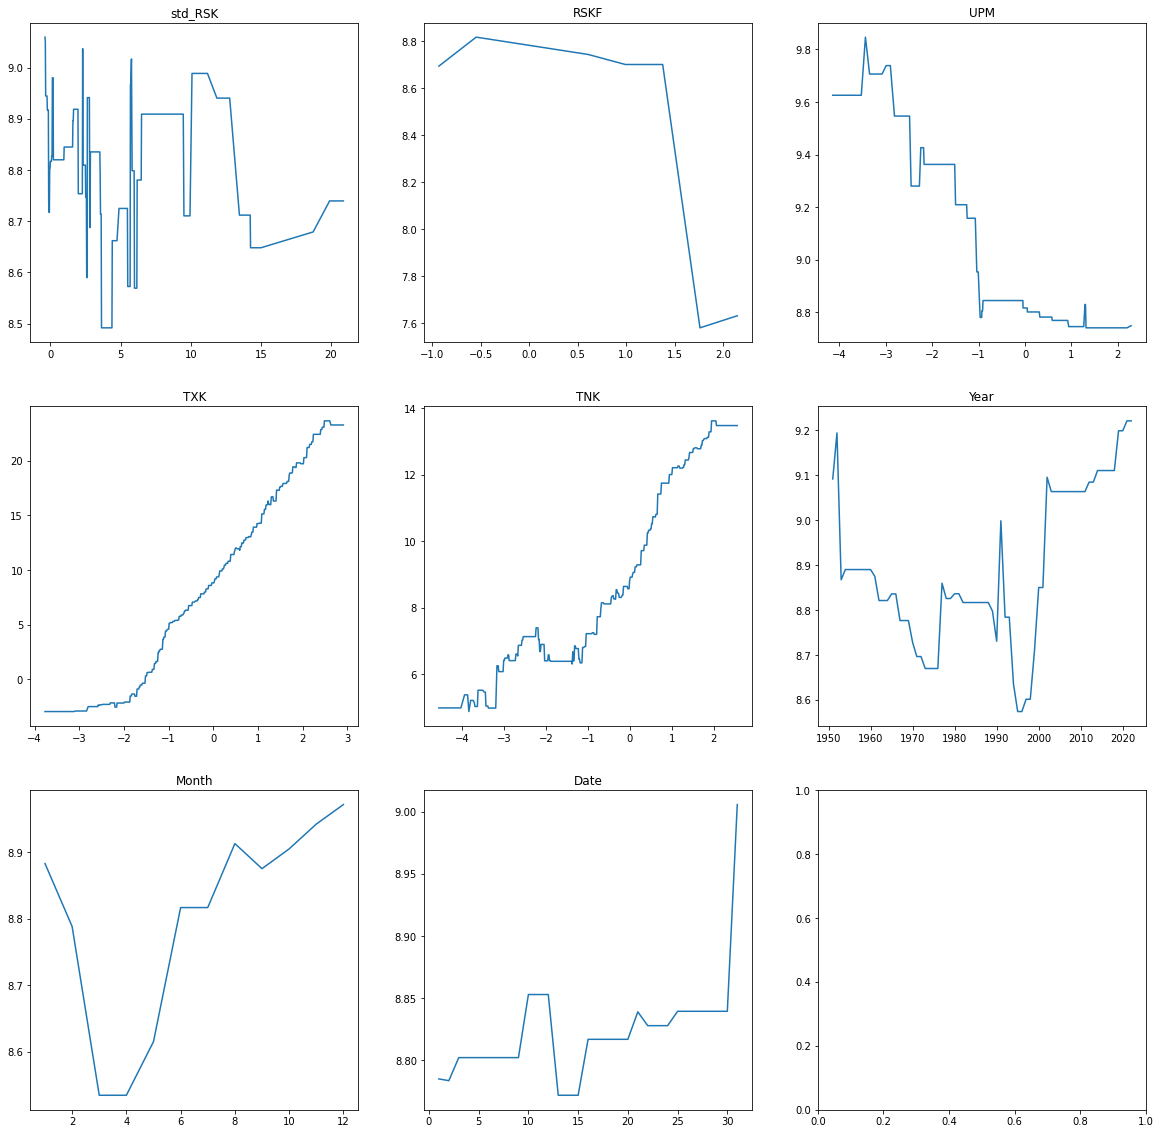

In [75]:
pdd_plot(X_train, xgb)

The steep increase of month in Mai and June is not explainable. And the steep fall on the 13th is also not explainable.

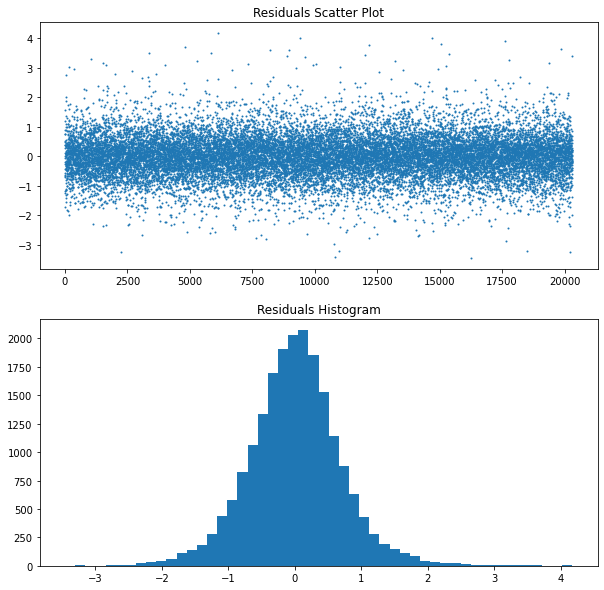

In [76]:
residual_plot(X_train, y_train, xgb)

Residual plot could not help us further. Maybe try a new model with only time-indicating variables. This is more practical because we only have the date, month, year as independent variables when trying to predict the future.

In [30]:
xgb1 = XGBRegressor(n_estimators=50)
xgb1.fit(X_train1, y_train1)
print("Score des XGB: ",str(xgb1.score(X_test1,y_test1)))

Score des XGB:  0.7710856488970628


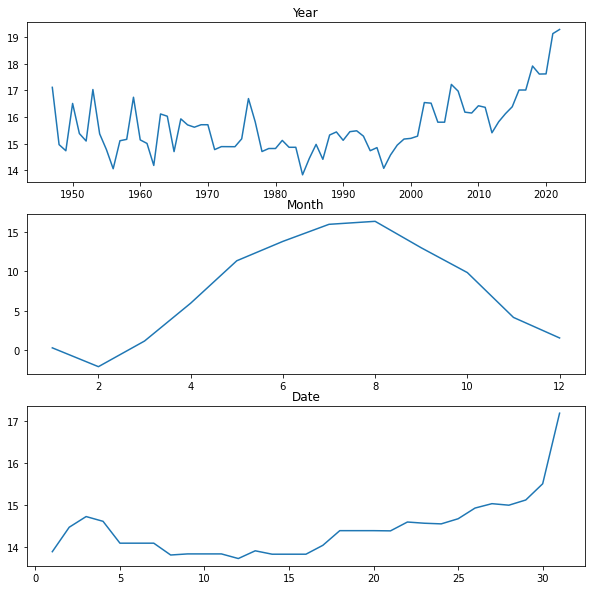

In [42]:
pdd_plot(X_train1, xgb1)

Temperature based on months are now much more plausible, although accuracy score is a bit lower.

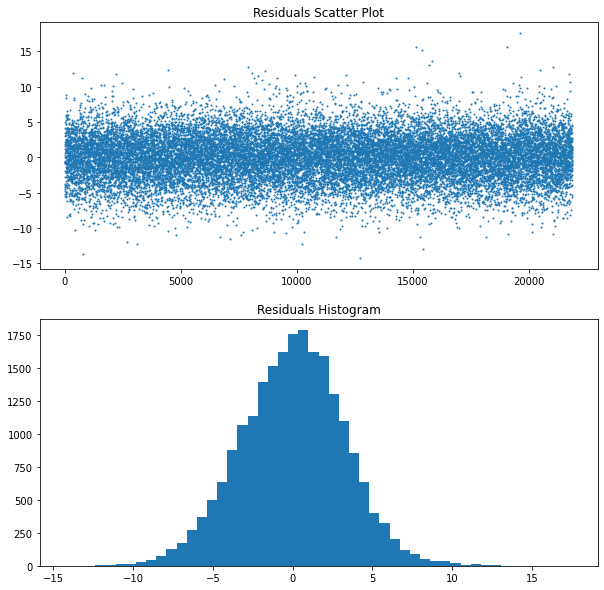

In [72]:
residual_plot(X_train1, y_train1, xgb1)

### Neuron Network

In [24]:
from sklearn.neural_network import MLPRegressor

hyperparameter_df = pd.DataFrame(columns=['Hidden layers size', 'learning rate', 'max_iter', 'R_squared'])
def neural_net_model(hid_size, learning_rate, max_iter): #given that learning rate is constant
    neural_net = MLPRegressor(random_state=1,max_iter = max_iter, hidden_layer_sizes=hid_size, learning_rate_init = learning_rate).fit(X_train, y_train)
    #y_pred_nn = neural_net.predict(X_test)
    R_squared = neural_net.score(X_test, y_test)
    return R_squared
for hid_size in [10,15,20]:
    for learning_rate in [0.001, 0.01, 0.1]:
        for max_iter in [100,200,250,350]:
            result = neural_net_model(hid_size, learning_rate, max_iter)
            hyperparameter_df.loc[len(hyperparameter_df)] = hid_size,learning_rate,max_iter, result
            '''print('Hidden layers size, learning rate, max_iter: ', hid_size,', ',learning_rate,', ',max_iter)
            print('R_squared: ', result)'''
pd.set_option('display.max_rows', None)
hyperparameter_df

,Hidden layers size,learning rate,max_iter,R_squared
0,10.0,0.001,100.0,0.982521
1,10.0,0.001,200.0,0.982521
2,10.0,0.001,250.0,0.982521
3,10.0,0.001,350.0,0.982521
4,10.0,0.010,100.0,0.982298
5,10.0,0.010,200.0,0.982298
6,10.0,0.010,250.0,0.982298
7,10.0,0.010,350.0,0.982298
8,10.0,0.100,100.0,0.981222
9,10.0,0.100,200.0,0.981222


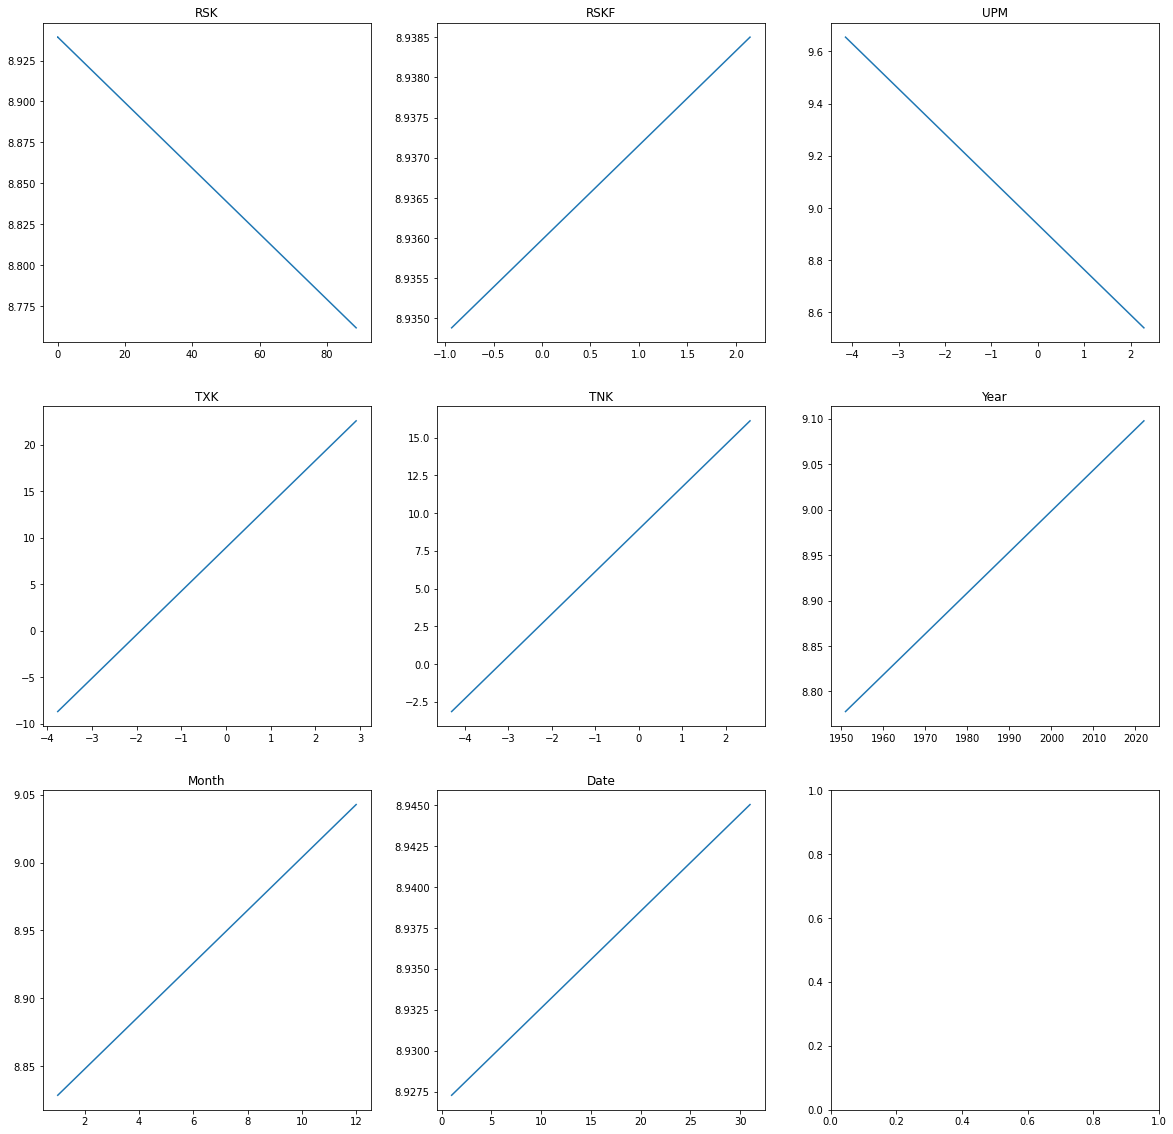

In [68]:
nn_model = MLPRegressor(random_state=10,max_iter = 100,learning_rate_init = 0.001, hidden_layer_sizes=10).fit(X_train, y_train)
pdd_plot(X_train, nn_model)

This model still could not get the month >< temperature right. Temperature in summer, between June and August, should be the highest but the graph shows a straight linear relationship from January to December.

In [67]:
hyperparameter_df1 = pd.DataFrame(columns=['Hidden layers size', 'learning rate', 'max_iter', 'R_squared'])
def neural_net_model1(hid_size, learning_rate, max_iter): #given that learning rate is constant
    neural_net = MLPRegressor(random_state=1,max_iter = max_iter, hidden_layer_sizes=hid_size, learning_rate_init = learning_rate).fit(X_train1, y_train1)
    #y_pred_nn = neural_net.predict(X_test)
    R_squared = neural_net.score(X_test1, y_test1)
    return R_squared
for hid_size in [3,5,10]:
    for learning_rate in [0.001, 0.01, 0.1]:
        for max_iter in [100,200,250,350]:
            result = neural_net_model1(hid_size, learning_rate, max_iter)
            hyperparameter_df1.loc[len(hyperparameter_df1)] = hid_size,learning_rate,max_iter, result
            '''print('Hidden layers size, learning rate, max_iter: ', hid_size,', ',learning_rate,', ',max_iter)
            print('R_squared: ', result)'''
pd.set_option('display.max_rows', None)
hyperparameter_df1

,Hidden layers size,learning rate,max_iter,R_squared
0,3.0,0.001,100.0,0.053159
1,3.0,0.001,200.0,0.053159
2,3.0,0.001,250.0,0.053159
3,3.0,0.001,350.0,0.053159
4,3.0,0.010,100.0,-0.020562
5,3.0,0.010,200.0,-0.020562
6,3.0,0.010,250.0,-0.020562
7,3.0,0.010,350.0,-0.020562
8,3.0,0.100,100.0,-0.000303
9,3.0,0.100,200.0,-0.000303


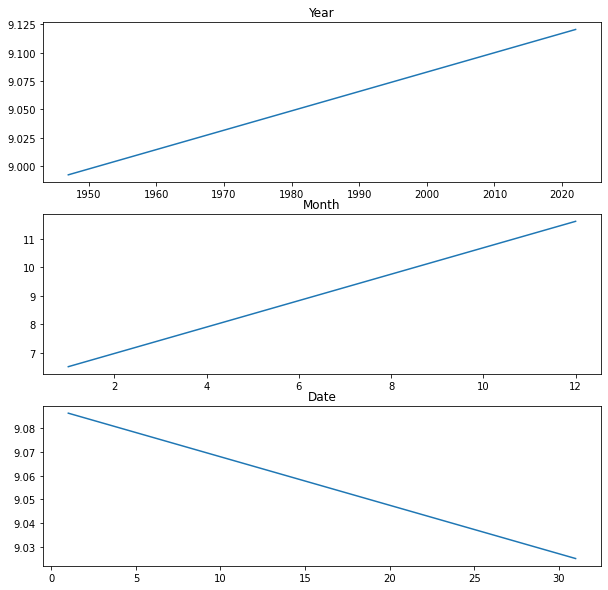

In [43]:
nn_model1 = MLPRegressor(random_state=10,max_iter = 100,learning_rate_init = 0.001, hidden_layer_sizes= 3).fit(X_train1, y_train1)
pdd_plot(X_train1, nn_model1)
        